HEADER: "Time","V1","V2","V3","V4","V5","V6","V7","V8","V9","V10","V11","V12","V13","V14","V15","V16","V17","V18","V19","V20","V21","V22","V23","V24","V25","V26","V27","V28","Amount","Class"
EXAMPLE FEATURES: [0.0, -1.3598071336738, -0.0727811733098497, 2.53634673796914, 1.37815522427443, -0.338320769942518, 0.462387777762292, 0.239598554061257, 0.0986979012610507, 0.363786969611213, 0.0907941719789316, -0.551599533260813, -0.617800855762348, -0.991389847235408, -0.311169353699879, 1.46817697209427, -0.470400525259478, 0.207971241929242, 0.0257905801985591, 0.403992960255733, 0.251412098239705, -0.018306777944153, 0.277837575558899, -0.110473910188767, 0.0669280749146731, 0.128539358273528, -0.189114843888824, 0.133558376740387, -0.0210530534538215, 149.62]
features.shape: (284807, 30)
targets.shape: (284807, 1)


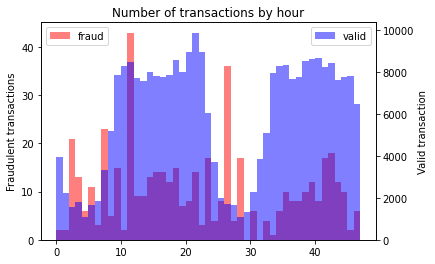

Number of training samples: 227846
Number of validation samples: 56961


In [9]:
###Credit fraud detection model, imbalanced classification, data taken from https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
###First model example taken from https://keras.io/examples/structured_data/imbalanced_classification/
###This model is lackluster. I want to improve it.
###Code/comments written by me are indicated with triple-###

#Setup
import csv
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from numpy.core.arrayprint import format_float_scientific
#np.random.seed(2082023)

#Vectorize CSV Data
fname = "/content/creditcard.csv"
all_features = []
all_targets = []
with open(fname) as f:
    for i, line in enumerate(f):
        if i == 0:
            print("HEADER:", line.strip())
            continue  # Skip header
        fields = line.strip().split(",")
        all_features.append([float(v.replace('"', "")) for v in fields[:-1]])
        all_targets.append([int(fields[-1].replace('"', ""))])
        if i == 1:
            print("EXAMPLE FEATURES:", all_features[-1])

features = np.array(all_features, dtype="float32")
targets = np.array(all_targets, dtype="uint8")
print("features.shape:", features.shape)
print("targets.shape:", targets.shape)

###Convert seconds into hours for easier binning/analysis
features[:,0] = features[:,0] / 3600

#Preparing Validation Set
###A shuffling step step did not exist in the example model given by the keras.io page, effectively using the first 20% of the observations by time as the
###validation set; the data was trained on transactions from e.g. 1 PM - 5 PM, then validated on transactions from 12 PM - 1 PM. This is a bad assumption if the time of
###the transaction has any effect on spending or fraud habits, which the non-uniform distribution of data points suggests.
bins = np.arange(0,np.ceil(max(features[:,0])),1,dtype=float)
fraud_indices = [i for i, row in enumerate(targets) if row[0]==1]
fraud_features = features[fraud_indices,0]
valid_indices = [i for i, row in enumerate(targets) if row[0]==0]
valid_features = features[valid_indices,0]

fig, ax1 = plt.subplots()
ax1.hist(fraud_features, bins, alpha=0.5, label="fraud", color="red")
ax1.set_ylabel("Fraudulent transactions")
ax2 = ax1.twinx()
ax2.hist(valid_features, bins, alpha=0.5, label="valid", color="blue")
ax2.set_ylabel("Valid transaction")
plt.xlabel("Time")
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.title("Number of transactions by hour")
plt.show()

shuffled_indices = np.arange(len(features))
np.random.shuffle(shuffled_indices)
shuffled_features = features[shuffled_indices]
shuffled_targets = targets[shuffled_indices]
###Features are now shuffled

num_val_samples = int(len(features) * 0.2)
train_features = features[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_features = features[-num_val_samples:]
val_targets = targets[-num_val_samples:]
shuffled_train_features = shuffled_features[:-num_val_samples]
shuffled_train_targets = shuffled_targets[:-num_val_samples]
shuffled_val_features = shuffled_features[-num_val_samples:]
shuffled_val_targets = shuffled_targets[-num_val_samples:]

print("Number of training samples:", len(train_features))
print("Number of validation samples:", len(val_features))

In [11]:
###Train The Model With class_weight Argument
def keras_io_train(m, shuf=True, use_time_var=True, w_0_correction = 1, w_1_correction = 1, 
                  bs=2048, e=30, lr=.01, loss_type="binary_crossentropy", reduce_lr=False):
  t_fs=train_features
  t_ts=train_targets
  v_fs=val_features
  v_ts=val_targets
  if shuf:
    t_fs=shuffled_train_features
    t_ts=shuffled_train_targets
    v_fs=shuffled_val_features
    v_ts=shuffled_val_targets

  if not use_time_var:
     t_fs=t_fs[1:]
     v_fs=v_fs[1:]

  #Analyze Class Imbalance
  counts = np.bincount(t_ts[:, 0])
  print(
      "Number of positive samples in training data: {} of {} ({:.3f}% of total)".format(
          counts[1], len(t_ts), 100 * float(counts[1]) / len(t_ts)
      )
  )
  #set comparative weights for positives and negatives
  weight_for_0 = 1.0 / counts[0]
  weight_for_1 = 1.0 / counts[1]
  class_weight = {0: weight_for_0*w_0_correction, 1: weight_for_1*w_1_correction}

  #Normalize Data Based On Training Set
  mean = np.mean(t_fs, axis=0)
  t_fs -= mean
  v_fs -= mean
  std = np.std(t_fs, axis=0)
  t_fs /= std
  v_fs /= std

  metrics = [
      keras.metrics.AUC(num_thresholds=200, curve="PR", name="PRAUC"),
      keras.metrics.AUC(num_thresholds=200, curve="ROC", name="ROCAUC"),
      keras.metrics.Precision(name="precision"),
      keras.metrics.Recall(name="recall"),
      keras.metrics.BinaryAccuracy(name="accuracy")
  ]

  m.compile(
      optimizer=keras.optimizers.Adam(lr), loss=loss_type, metrics=metrics
  )


  callbacks = [keras.callbacks.ModelCheckpoint("fraud_model_at_epoch_{epoch}.h5")]
  if reduce_lr: callbacks.append(keras.callbacks.ReduceLROnPlateau(monitor="val_PRAUC", factor=.8, patience=10))

  return m.fit(
      train_features,
      train_targets,
      batch_size=bs,
      epochs=e,
      verbose=2,
      callbacks=callbacks,
      validation_data=(val_features, val_targets),
      class_weight=class_weight,
  )

In [24]:
###Visualize Learning Curve
def keras_io_visualize(h, newh=0, tn=0):
  # list all data in history
  #print(h.history.keys())
  #if(newh): print(newh.history.keys())

  # # summarize history for precision
  # plt.plot(h.history['precision'], color='cyan', linestyle='dashed')
  # plt.plot(h.history['val_precision'], color='blue', linestyle='solid')
  # if(newh):
  #   plt.plot(newh.history['precision'], color='orange', linestyle='dashed')
  #   plt.plot(newh.history['val_precision'], color='red', linestyle='solid')
  #   plt.legend(['train', 'test', 'new_train', 'new_test'], loc='upper left')
  # else:
  #   plt.legend(['train', 'test'], loc='upper left')
  # plt.title('model ' + str(tn) + ' precision')
  # plt.ylabel('precision')
  # plt.xlabel('epoch')
  # plt.show()

  # # summarize history for recall
  # plt.plot(history.history['recall'], color='cyan', linestyle='dashed')
  # plt.plot(history.history['val_recall'], color='blue', linestyle='solid')
  # if(newh):
  #   plt.plot(newh.history['recall'], color='orange', linestyle='dashed')
  #   plt.plot(newh.history['val_recall'], color='red', linestyle='solid')
  #   plt.legend(['train', 'test', 'new_train', 'new_test'], loc='upper left')
  # else:
  #   plt.legend(['train', 'test'], loc='upper left')
  # plt.title('model ' + str(tn) + ' recall')
  # plt.ylabel('recall')
  # plt.xlabel('epoch')
  # plt.show()

  # # summarize history for accuracy
  # plt.plot(history.history['accuracy'], color='cyan', linestyle='dashed')
  # plt.plot(history.history['val_accuracy'], color='blue', linestyle='solid')
  # if(newh):
  #   plt.plot(newh.history['accuracy'], color='orange', linestyle='dashed')
  #   plt.plot(newh.history['val_accuracy'], color='red', linestyle='solid')
  #   plt.legend(['train', 'test', 'new_train', 'new_test'], loc='upper left')
  # else:
  #   plt.legend(['train', 'test'], loc='upper left')
  # plt.title('model ' + str(tn) + ' accuracy')
  # plt.ylabel('accuracy')
  # plt.xlabel('epoch')
  # plt.show()

  # # summarize history for ROCAUC
  # plt.plot(history.history['ROCAUC'], color='cyan', linestyle='dashed')
  # plt.plot(history.history['val_ROCAUC'], color='blue', linestyle='solid')
  # if(newh):
  #   plt.plot(newh.history['ROCAUC'], color='orange', linestyle='dashed')
  #   plt.plot(newh.history['val_ROCAUC'], color='red', linestyle='solid')
  #   plt.legend(['train', 'test', 'new_train', 'new_test'], loc='upper left')
  # else:
  #   plt.legend(['train', 'test'], loc='upper left')
  # plt.title('model ' + str(tn) + ' ROCAUC')
  # plt.ylabel('ROCAUC')
  # plt.xlabel('epoch')
  # plt.show()

  # summarize history for PRAUC
  plt.plot(history.history['PRAUC'], color='cyan', linestyle='dashed')
  plt.plot(history.history['val_PRAUC'], color='blue', linestyle='solid')
  if(newh):
    plt.plot(newh.history['PRAUC'], color='orange', linestyle='dashed')
    plt.plot(newh.history['val_PRAUC'], color='red', linestyle='solid')
    plt.legend(['train', 'test', 'new_train', 'new_test'], loc='upper left')
  else:
    plt.legend(['train', 'test'], loc='upper left')
  plt.title('model ' + str(tn) + ' PRAUC')
  plt.ylabel('PRAUC')
  plt.xlabel('epoch')
  plt.show()

  # prec_hist = h.history['val_precision']
  # print("original greatest val_precision of " + str(np.max(prec_hist)) + " at epoch " + str(np.argmax(prec_hist)))
  # recall_hist = h.history['val_recall']
  # print("original greatest val_recall of " + str(np.max(recall_hist)) + " at epoch " + str(np.argmax(recall_hist)))
  # acc_hist = h.history['val_accuracy']
  # print("original greatest val_accuracy of " + str(np.max(acc_hist)) + " at epoch " + str(np.argmax(acc_hist)))
  # ROCAUC_hist = h.history['val_ROCAUC']
  # print("original greatest val_ROCAUC of " + str(np.max(ROCAUC_hist)) + " at epoch " + str(np.argmax(ROCAUC_hist)))
  PRAUC_hist = h.history['val_PRAUC']
  print("original greatest val_PRAUC of {:.4f}".format(np.max(PRAUC_hist)) + " at epoch " + str(np.argmax(PRAUC_hist)))
  if(newh):
    # new_prec_hist = newh.history['val_precision']
    # print("new greatest val_precision of " + str(np.max(new_prec_hist)) + " at epoch " + str(np.argmax(new_prec_hist)))
    # new_recall_hist = newh.history['val_recall']
    # print("new greatest val_recall of " + str(np.max(new_recall_hist)) + " at epoch " + str(np.argmax(new_recall_hist)))
    # new_acc_hist = newh.history['val_accuracy']
    # print("new greatest val_accuracy of " + str(np.max(new_acc_hist)) + " at epoch " + str(np.argmax(new_acc_hist)))
    # new_ROCAUC_hist = newh.history['val_ROCAUC']
    # print("new greatest val_ROCAUC of " + str(np.max(new_ROCAUC_hist)) + " at epoch " + str(np.argmax(new_ROCAUC_hist)))
    new_PRAUC_hist = newh.history['val_PRAUC']
    print("new greatest val_PRAUC of {:.4f}".format(np.max(new_PRAUC_hist)) + " at epoch " + str(np.argmax(new_PRAUC_hist)))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 256)               7936      
                                                                 
 dense_13 (Dense)            (None, 256)               65792     
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_14 (Dense)            (None, 256)               65792     
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_15 (Dense)            (None, 1)                 257       
                                                                 
Total params: 139,777
Trainable params: 139,777
Non-tr

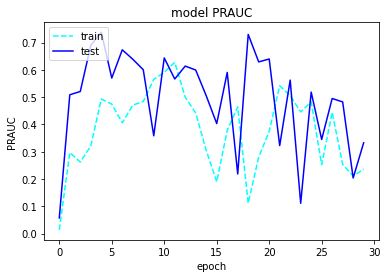

original greatest val_PRAUC of 0.7380869388580322 at epoch 4


In [12]:
#Build Binary Classification Model
test_num = 0
model = keras.Sequential(
    [
        keras.layers.Dense(
            256, activation="relu", input_shape=(train_features.shape[-1],)
        ),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)
model.summary()

history = keras_io_train(m=model)
keras_io_visualize(history)

### This is the original model given by keras.io, shuffled and unshuffled

In [26]:
###Build new model

# original model from keras.io had a greatest val_PRAUC of 0.7381 at epoch 12

### 1) Changing number of units on each layer to ramp up
### 2) Changing dropout layers to gaussian noise to avoid total loss of units
### 3) Add a fourth dense layer plus another noise layer
### 4) Reduce learning rate from 0.01 to 0.005 to smooth learning curve

# new greatest val_PRAUC of 0.8110 at epoch 26

### 5) Increase number of units in last layer
### 6) Remove gaussian noise on last layer and change second noise layer to dropout

# new greatest val_PRAUC of 0.8326 at epoch 24

### 7) Refactor and prepare for long term training. Combine Dropout and Gaussian noise.
### Trim neurons such that the number of neurons per layer is always decreasing; the first
### hidden layer has a base value of 256, but uses dropout, and so gets a 1/(1-.1) factor
### increase in the number of neurons to compensate. The next hidden layer has a base of 256,
### is increased by a factor of 1/(1-.15). The final has a base of 256 as well and is also
### adjusted. The result is a gradual ladder of layer complexity. Hopefully this works.

# new greatest val_PRAUC of 0.7782 at epoch 23

### 8) Promising trend upwards on the graph but worse maximum performance. Nee
### better consistency. Swapping noise for regular dropout.

# new greatest val_PRAUC of 0.8065 at epoch 29

### 9) The upward trend seems to strengthen. Increasing learning rate for one last test before
### long term training.

# new greatest val_PRAUC of 0.8111 at epoch 29

### 10) Reduce neurons by half.

# new greatest val_PRAUC of 0.7958 at epoch 9

### 11) Manually affect weight to increase priority on fraudulent transactions

# new greatest val_PRAUC of 0.8001 at epoch 18

test_num += 1
new_model = keras.Sequential(
    [
        keras.layers.Dense(
            128, activation="relu", input_shape=(train_features.shape[-1],)
        ),
        keras.layers.Dense(142, activation="relu"),
        keras.layers.Dropout(0.1),
        keras.layers.GaussianDropout(0.1),
        keras.layers.Dense(150, activation="relu"),
        keras.layers.Dropout(0.15),
        keras.layers.GaussianDropout(0.15),
        keras.layers.Dense(160, activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.GaussianDropout(0.2),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)
new_model.summary()
new_history = keras_io_train(m=new_model, e=30, lr=0.005, reduce_lr=True, w_1_correction=1.1)
keras_io_visualize(h=history, newh=new_history, tn=test_num)



Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 128)               3968      
                                                                 
 dense_41 (Dense)            (None, 142)               18318     
                                                                 
 dropout_20 (Dropout)        (None, 142)               0         
                                                                 
 gaussian_dropout_12 (Gaussi  (None, 142)              0         
 anDropout)                                                      
                                                                 
 dense_42 (Dense)            (None, 150)               21450     
                                                                 
 dropout_21 (Dropout)        (None, 150)               0         
                                                      

TypeError: ignored

In [ ]:
###Best altered model so far had a 10-point PRAUC score increase. I'm going to be messing with this more.